<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/exercises/ex2/Exercise_2_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

### Source: [link](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#exercise-computing-word-embeddings-continuous-bag-of-words)

# Word Embeddings: Encoding Lexical Semantics

Word embeddings are dense vectors of real numbers, one per word in your
vocabulary. In NLP, it is almost always the case that your features are
words! But how should you represent a word in a computer? You could
store its ascii character representation, but that only tells you what
the word *is*, it doesn't say much about what it *means* (you might be
able to derive its part of speech from its affixes, or properties from
its capitalization, but not much). Even more, in what sense could you
combine these representations? We often want dense outputs from our
neural networks, where the inputs are $|V|$ dimensional, where
$V$ is our vocabulary, but often the outputs are only a few
dimensional (if we are only predicting a handful of labels, for
instance). How do we get from a massive dimensional space to a smaller
dimensional space?

How about instead of ascii representations, we use a one-hot encoding?
That is, we represent the word $w$ by

\begin{align}\overbrace{\left[ 0, 0, \dots, 1, \dots, 0, 0 \right]}^\text{|V| elements}\end{align}

where the 1 is in a location unique to $w$. Any other word will
have a 1 in some other location, and a 0 everywhere else.

There is an enormous drawback to this representation, besides just how
huge it is. It basically treats all words as independent entities with
no relation to each other. What we really want is some notion of
*similarity* between words. Why? Let's see an example.

Suppose we are building a language model. Suppose we have seen the
sentences

* The mathematician ran to the store.
* The physicist ran to the store.
* The mathematician solved the open problem.

in our training data. Now suppose we get a new sentence never before
seen in our training data:

* The physicist solved the open problem.

Our language model might do OK on this sentence, but wouldn't it be much
better if we could use the following two facts:

* We have seen  mathematician and physicist in the same role in a sentence. Somehow they
  have a semantic relation.
* We have seen mathematician in the same role  in this new unseen sentence
  as we are now seeing physicist.

and then infer that physicist is actually a good fit in the new unseen
sentence? This is what we mean by a notion of similarity: we mean
*semantic similarity*, not simply having similar orthographic
representations. It is a technique to combat the sparsity of linguistic
data, by connecting the dots between what we have seen and what we
haven't. This example of course relies on a fundamental linguistic
assumption: that words appearing in similar contexts are related to each
other semantically. This is called the `distributional
hypothesis <https://en.wikipedia.org/wiki/Distributional_semantics>`__.


# Getting Dense Word Embeddings

How can we solve this problem? That is, how could we actually encode
semantic similarity in words? Maybe we think up some semantic
attributes. For example, we see that both mathematicians and physicists
can run, so maybe we give these words a high score for the "is able to
run" semantic attribute. Think of some other attributes, and imagine
what you might score some common words on those attributes.

If each attribute is a dimension, then we might give each word a vector,
like this:

\begin{align}q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
   \overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]\end{align}

\begin{align}q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
   \overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]\end{align}

Then we can get a measure of similarity between these words by doing:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = q_\text{physicist} \cdot q_\text{mathematician}\end{align}

Although it is more common to normalize by the lengths:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
   {\| q_\text{\physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)\end{align}

Where $\phi$ is the angle between the two vectors. That way,
extremely similar words (words whose embeddings point in the same
direction) will have similarity 1. Extremely dissimilar words should
have similarity -1.


You can think of the sparse one-hot vectors from the beginning of this
section as a special case of these new vectors we have defined, where
each word basically has similarity 0, and we gave each word some unique
semantic attribute. These new vectors are *dense*, which is to say their
entries are (typically) non-zero.

But these new vectors are a big pain: you could think of thousands of
different semantic attributes that might be relevant to determining
similarity, and how on earth would you set the values of the different
attributes? Central to the idea of deep learning is that the neural
network learns representations of the features, rather than requiring
the programmer to design them herself. So why not just let the word
embeddings be parameters in our model, and then be updated during
training? This is exactly what we will do. We will have some *latent
semantic attributes* that the network can, in principle, learn. Note
that the word embeddings will probably not be interpretable. That is,
although with our hand-crafted vectors above we can see that
mathematicians and physicists are similar in that they both like coffee,
if we allow a neural network to learn the embeddings and see that both
mathematicians and physicists have a large value in the second
dimension, it is not clear what that means. They are similar in some
latent semantic dimension, but this probably has no interpretation to
us.


In summary, **word embeddings are a representation of the *semantics* of
a word, efficiently encoding semantic information that might be relevant
to the task at hand**. You can embed other things too: part of speech
tags, parse trees, anything! The idea of feature embeddings is central
to the field.


# Word Embeddings in Pytorch

Before we get to a worked example and an exercise, a few quick notes
about how to use embeddings in Pytorch and in deep learning programming
in general. Similar to how we defined a unique index for each word when
making one-hot vectors, we also need to define an index for each word
when using embeddings. These will be keys into a lookup table. That is,
embeddings are stored as a $|V| \times D$ matrix, where $D$
is the dimensionality of the embeddings, such that the word assigned
index $i$ has its embedding stored in the $i$'th row of the
matrix. In all of my code, the mapping from words to indices is a
dictionary named word\_to\_ix.

The module that allows you to use embeddings is torch.nn.Embedding,
which takes two arguments: the vocabulary size, and the dimensionality
of the embeddings.

To index into this table, you must use torch.LongTensor (since the
indices are integers, not floats).




In [1]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import json
from collections import Counter
torch.manual_seed(1)

In [2]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward0>)


# An Example: N-Gram Language Modeling

Recall that in an n-gram language model, given a sequence of words
$w$, we want to compute

\begin{align}P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} )\end{align}

Where $w_i$ is the ith word of the sequence.

In this example, we will compute the loss function on some training
examples and update the parameters with backpropagation.

In [3]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss() # Negative Log Likelihood Loss
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    print("Loss in Epoch {ep}: {l}".format(ep=epoch, l=np.round(total_loss, 2))) # The loss decreased every iteration over the training data!
    losses.append(total_loss)

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
Loss in Epoch 0: 522.23
Loss in Epoch 1: 519.69
Loss in Epoch 2: 517.16
Loss in Epoch 3: 514.65
Loss in Epoch 4: 512.16
Loss in Epoch 5: 509.68
Loss in Epoch 6: 507.21
Loss in Epoch 7: 504.75
Loss in Epoch 8: 502.31
Loss in Epoch 9: 499.88


# Exercise: Computing Word Embeddings: Continuous Bag-of-Words

The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize

\begin{align}-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)\end{align}

where $q_w$ is the embedding for word $w$.


## Exercise Layout
### 1. <u>Training CBOW Embeddings</u>
1.1) Implement a CBOW Model by completing ```class CBOW(nn.Module)``` and train it on ```raw_text```.    

1.2) Load Datasets ```tripadvisor_hotel_reviews_reduced.csv``` and ```scifi_reduced.txt```.     

1.3) Decide preprocessing steps by completing the function ```def custom_preprocess()```. Describe your decisions. Note that it's your choice to create different preprocessing functions for hotel reviews and scifi datasets or use the same preprocessing function.             

1.4) Train CBOW2 with a context width of 2 (in both directions) for the Hotel Reviews dataset.   

1.5) Train CBOW5 with a context width of 5 (in both directions) for the Hotel Reviews dataset. Are predictions made by the model sensitive towards the context size?
     
1.6) Train CBOW2 with a context width of 2 (in both directions) for the Sci-Fi story dataset.  


### 2. <u>Test your Embeddings</u>
Note - Do the following for CBOW2, and optionally for CBOW5

2.1) For the hotel reviews dataset, choose 3 nouns, 3 verbs, and 3 adjectives. Make sure that some nouns/verbs/adjectives occur frequently in the corpus and that others are rare. For each of the 9 chosen words, retrieve the 5 closest words according to your trained CBOW2 model. List them in your report and comment on the performance of your model: do the neighbours the model provides make sense? Discuss.   

2.2) Do the same for Sci-Fi dataset.   

2.3) How does the quality of the hotel review-based embeddings compare with the Sci-fi-based embeddings? Elaborate.   

2.4) Choose 2 words and retrieve their 5 closest neighbours according to hotel review-based embeddings and the Sci-fi-based embeddings. Do they have different neighbours? If yes, can you reason why?    

2.5) What are the differences between CBOW2 and CBOW5 ? Can you "describe" them?   


### Tips

1. Switch from CPU to a GPU instance after you have confirmed that your training procedure is working correctly.
2. You can always save your intermediate results (embeddings, preprocessed dataset, model, etc.) in your google drive via colab



### 1.1 Create a CBOW Model by completing ```class CBOW(nn.Module)``` and test it on ```raw_text```
Implement CBOW in Pytorch by filling in the class below. Some
tips:

* Think about which parameters you need to define.
* Make sure you know what shape each operation expects. Use .view() if you need to
  reshape.

In [3]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
# print(data[:5])


class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW,self).__init__()
        self.embedding_dim = embedding_dim
        self.context_size = context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim*2, 128)
        self.linear2 = nn.Linear(128,vocab_size)

        nn.init.kaiming_uniform_(self.linear1.weight, nonlinearity = 'relu')
        nn.init.xavier_uniform_(self.linear2.weight)

    def forward(self, inputs):
        #flatten the embeddings: batch * (context_size * embed_dim *2)
        embeds = self.embeddings(inputs).view((-1, self.context_size*self.embedding_dim*2))
        h1 = F.relu(self.linear1(embeds))
        h2 = self.linear2(h1)
        neg_log_probs = F.log_softmax(h2, dim=1)
        return neg_log_probs

# create your model and train.  here are some functions to help you make
# the data ready for use by your module


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


# make_context_vector(data[0][0], word_to_ix)  # example

### 1.2 Load Datasets

In [ ]:
### Load Datasets tripadvisor_hotel_reviews_reduced.csv and scifi_reduced.txt

!gdown 1foE1JuZJeu5E_4qVge9kExzhvF32teuF # For Hotel Reviews
!gdown 13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75 # For Scifi-Text

Downloading...
From: https://drive.google.com/uc?id=1foE1JuZJeu5E_4qVge9kExzhvF32teuF
To: /content/tripadvisor_hotel_reviews_reduced.csv
100% 7.36M/7.36M [00:00<00:00, 37.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75
To: /content/scifi_reduced.txt
100% 43.1M/43.1M [00:00<00:00, 68.9MB/s]


### 1.3 Preprocess Datasets
### 🗒❓ Describe your decisions for preprocessing the datasets

In [12]:
### Complete the preprocessing function and apply it to the datasets

# We use spacy to preprocess the datasets, 
# if spacy is not installed on colab, please uncomment the following two lines to install it

# !pip install spacy
# !python -m spacy download en_core_web_sm

import spacy
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

nlp_en = spacy.load("en_core_web_sm", disable = ["ner", "parser"])

def preprocess(example, dataset = "hotel", nlp = nlp_en):
    
    if dataset == "hotel":
        raw = " ".join([w for ls in [w.split(".") for w in example.split(" ")] for w in ls]) # split "xx.xxx"
        doc = nlp_en(raw)
        # Since the hotel review dataset has been preprocessed, we only remove digits and punct
        doc = [w.lemma_ for w in doc if not w.like_num and not w.is_punct and w.text !=" "]

    elif dataset == "scifi":
        doc = nlp_en(example)
        # remove punctuations and stopwords and lemmatise to align with the hotel dataset
        doc = [w.lemma_ for w in doc if not w.is_stop and
            not w.is_punct and not w.is_digit][1:-1]

    return doc



In [13]:
# preprocess the hotel dataset
raw_hotel = pd.read_csv("tripadvisor_hotel_reviews_reduced.csv")
print("----------Start preprocessing the hotel dataset----------")
preprocessed_hotel = raw_hotel["Review"].progress_apply(preprocess).to_list()
print("Done.")

----------Start preprocessing the hotel dataset----------


100%|██████████| 10000/10000 [01:03<00:00, 158.43it/s]

Done.


In [14]:
# preprocess the sci-fi text dataset
input = open("scifi_reduced.txt")
with input as i:
    raw_scifi = i.read()
    print("----------Start preprocessing the scifi dataset----------")
    # Truncate the dataset so it won't exceed the nlp pipe's processing limit
    preprocessed_scifi = []
    num_chunk = 10000
    for i in tqdm(range(num_chunk)):
        chunk_size = int(len(raw_scifi)/num_chunk)
        chunk = raw_scifi[i*chunk_size:(i+1)*chunk_size]
        preprocessed_chunk = preprocess(chunk, dataset="scifi")
        preprocessed_scifi.extend(preprocessed_chunk)
    print("Done.")

----------Start preprocessing the scifi dataset----------


100%|██████████| 10000/10000 [06:08<00:00, 27.15it/s]

Done.


In [15]:
def save_preprocessed(data, fp):
    with open(fp, "x") as out:
        json.dump(data, out)

save_preprocessed(preprocessed_hotel, "preprocessed_hotel.json")
save_preprocessed(preprocessed_scifi, "preprocessed_scifi.json")

### 1.4 Train CBOW2 with a context width of 2 (in both directions) for the Hotel Reviews dataset.

In [4]:
# prepare the datasets

from torch.utils.data import Dataset, DataLoader, random_split

class CBOWdataset(Dataset):
    def __init__(self, context_len, data = "hotel"):

        self.data = []

        if data == "hotel":
            fp = "preprocessed_hotel.json"
            with open(fp, 'r') as file:
                preprocessed_hotel = json.load(file)
            dat = [token for exp in preprocessed_hotel for token in exp] #flatten
            vocab = set(dat)
            self.freq_dist = Counter(dat) # create a freq dist
            for review in preprocessed_hotel:
                for i in range(context_len, len(review) - context_len):
                    context = review[i-context_len:i] + review[i+1:i+context_len+1] #left+right
                    target = review[i]
                    self.data.append((context, target))

        elif data == "scifi":
            fp = "preprocessed_scifi.json"
            with open(fp, 'r') as file:
                preprocessed_scifi = json.load(file)
            dat = [token for token in preprocessed_scifi]
            vocab = set(dat)
            self.freq_dist = Counter(dat)
            for i in range(context_len, len(preprocessed_scifi) - context_len):
                context = preprocessed_scifi[i-context_len:i] + preprocessed_scifi[i+1:i+context_len+1] #left+right
                target = preprocessed_scifi[i]
                self.data.append((context, target))

        self.vocab_size = len(vocab)
        self.word_to_ix = {word: i for i, word in enumerate(vocab)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]
        context_tensor = self._make_context_vector(context)
        target_tensor = torch.tensor(self.word_to_ix[target], dtype=torch.long)
        return context_tensor, target_tensor

    def _make_context_vector(self, context):
        idxs = [self.word_to_ix[w] for w in context]
        return torch.tensor(idxs, dtype=torch.long)

    def vocab_size(self):
        return self.vocab_size



In [5]:

# split the dataset into train and validation, each taking up 80% and 20% of the data
full_hotel_dataset = CBOWdataset(context_len=2)
hotel_train_data, hotel_val_data = random_split(full_hotel_dataset,
                                                [0.8, 0.2])

print(hotel_train_data[100])

hotel_train_loader = DataLoader(hotel_train_data, batch_size=1024, shuffle=True)
hotel_val_loader = DataLoader(hotel_val_data, batch_size=1024, shuffle=False)

(tensor([29692,   240,  7629, 29080]), tensor(28508))


In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot(train_losses, val_losses=None):
    fig, ax1 = plt.subplots()
    ax1.plot(train_losses, label = "train_loss")
    if val_losses:
        ax1.plot(val_losses, label = "val_loss")

    ax1.legend()
    # plt.plot(accs)
    ax1.set_ylabel('Avg Negative Likelihood Loss')
    plt.xlabel('Epoch')
    plt.show()

In [7]:
import copy

def train(model,
          train_loader,
          val_loader = None,
          num_epoches = 20,
          lr=0.01,
          patience=5,
          delta = 0.01):
    # train the model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training will start on {device}")

    loss_function = nn.NLLLoss(reduction="sum")

    def validation_step(model, dataloader, num_examples):
        val_loss = 0

        for idx, (context, target) in enumerate(dataloader):
            context = context.to(device)
            target = target.to(device)
            out = model(context)
            loss = loss_function(out, target)

            val_loss+=loss

        return val_loss/num_examples # return avg loss

    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    best_loss = float("inf") #for early stopping
    best_model_weights = None
    patience_counter = patience

    for epoch in range(num_epoches):

        model.train()
        avg_loss = 0
        avg_val_loss = 0
        for batch_idx, (context, target) in enumerate(train_loader):
            context = context.to(device)
            target = target.to(device)

            model.zero_grad()
            out = model(context)
            loss = loss_function(out, target)
            loss.backward()
            avg_loss += loss.item()

            optimizer.step()


        num_train_examples = len(train_loader) * train_loader.batch_size
        train_loss = avg_loss/num_train_examples
        train_losses.append(train_loss)

        if val_loader:
            # enter validation step if there is a validation set
            model.eval()
            with torch.set_grad_enabled(False):

                #validation
                num_val_examples = len(val_loader) * val_loader.batch_size
                val_loss = validation_step(model, val_loader, num_val_examples)
                val_losses.append(val_loss.cpu())
                print("-"*30)
                print("""Epoch: %03d/%03d\nAverage Training Loss: %.2f\nAverage Validation Loss: %.2f"""
                  % (epoch+1, num_epoches, train_loss, val_loss))
                print("-"*30)

                #early stopping
                if val_loss < best_loss-delta:
                    best_loss = val_loss
                    best_model_weights = copy.deepcopy(model.state_dict())
                    patience_counter = patience  # Reset patience counter
                    print(f"Still improving, reset patience counter to {patience}.")
                else:
                    patience_counter -= 1
                    if patience_counter == 0:
                        print(f"Early stopping was reached!")
                        break
                    print(f"No substantial improvement, {patience_counter} epoch(es) till stop.")
    # loss graph
    if val_loader:
        plot(train_losses, val_losses)
    else: plot(train_losses)
    print("-"*30)

    model.load_state_dict(best_model_weights)
    return model, best_model_weights


Training will start on cuda
------------------------------
Epoch: 001/020
Average Training Loss: 8.10
Average Validation Loss: 7.31
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 002/020
Average Training Loss: 7.16
Average Validation Loss: 7.01
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 003/020
Average Training Loss: 6.91
Average Validation Loss: 6.84
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 004/020
Average Training Loss: 6.75
Average Validation Loss: 6.77
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 005/020
Average Training Loss: 6.63
Average Validation Loss: 6.72
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 006/020
Average Training Loss

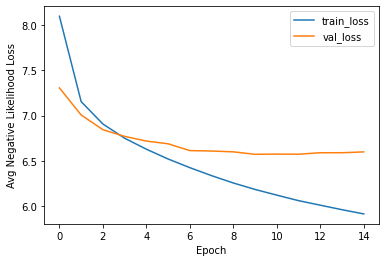

------------------------------


In [8]:
# model parameters
embedding_dim=50
context_size=2

model_hotel_2 = CBOW(full_hotel_dataset.vocab_size, embedding_dim, context_size)

model_hotel_2_trained, model_hotel_2_weights = train(model_hotel_2,
                                                     hotel_train_loader,
                                                     hotel_val_loader)

### 1.5 Train CBOW5 with a context width of 5 (in both directions) for the Hotel Reviews dataset.  

🗒❓ Are predictions made by the model sensitive towards the context size?

Sanity check: (tensor([ 3960, 17167, 18381, 32106,  2582, 32106, 17226,  7212, 11513, 12572]), tensor(14306))
Training will start on cuda
------------------------------
Epoch: 001/020
Average Training Loss: 8.26
Average Validation Loss: 7.72
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 002/020
Average Training Loss: 7.59
Average Validation Loss: 7.56
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 003/020
Average Training Loss: 7.48
Average Validation Loss: 7.51
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 004/020
Average Training Loss: 7.42
Average Validation Loss: 7.48
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 005/020
Average Training Loss: 7.37
Average Validation Loss: 7.46
------------------------------
Sti

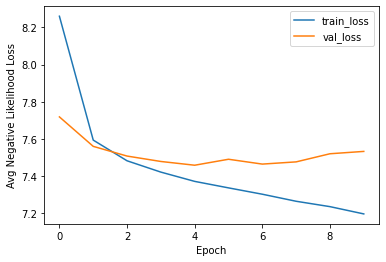

------------------------------


In [9]:
# model parameters
embedding_dim=50
context_size=5

# split the dataset into train and validation, each taking up 80% and 20% of the data
full_hotel_5_dataset = CBOWdataset(context_len=context_size)
hotel_5_train_data, hotel_5_val_data = random_split(full_hotel_5_dataset,
                                                    [0.8, 0.2])

print(f"Sanity check: {hotel_5_train_data[100]}")

hotel_5_train_loader = DataLoader(hotel_5_train_data, batch_size=1024, shuffle=True)
hotel_5_val_loader = DataLoader(hotel_5_val_data, batch_size=1024, shuffle=False)

model_hotel_5 = CBOW(full_hotel_5_dataset.vocab_size, embedding_dim, context_size)

model_hotel_5_trained, model_hotel_5_weights = train(model_hotel_5,
                                                     hotel_5_train_loader,
                                                     hotel_5_val_loader)

### 1.6 Train CBOW2 with a context width of 2 (in both directions) for the Sci-Fi story dataset

Sanity check: (tensor([46281, 67769, 73286, 51213]), tensor(49402))
Training will start on cuda
------------------------------
Epoch: 001/020
Average Training Loss: 8.84
Average Validation Loss: 8.61
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 002/020
Average Training Loss: 8.46
Average Validation Loss: 8.46
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 003/020
Average Training Loss: 8.26
Average Validation Loss: 8.39
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 004/020
Average Training Loss: 8.11
Average Validation Loss: 8.35
------------------------------
Still improving, reset patience counter to 5.
------------------------------
Epoch: 005/020
Average Training Loss: 8.00
Average Validation Loss: 8.32
------------------------------
Still improving, reset patience counter to 5.

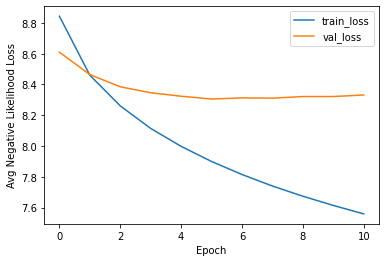

------------------------------


In [10]:
# model parameters
embedding_dim=50
context_size=2

# split the dataset into train and validation, each taking up 80%, 20% of the data
full_scifi_dataset = CBOWdataset(context_len=context_size, data="scifi")
scifi_train_data, scifi_val_data = random_split(full_scifi_dataset,
                                                [0.8, 0.2])

print(f"Sanity check: {scifi_train_data[100]}")

scifi_train_loader = DataLoader(scifi_train_data, batch_size=1024, shuffle=True)
scifi_val_loader = DataLoader(scifi_val_data, batch_size=1024, shuffle=False)

model_scifi_2 = CBOW(full_scifi_dataset.vocab_size, embedding_dim, context_size)

model_scifi_2_trained, model_scifi_2_weights = train(model_scifi_2,
                                                     scifi_train_loader,
                                                     scifi_val_loader)

### 2.1 For the hotel reviews dataset, choose 3 nouns, 3 verbs, and 3 adjectives. (CBOW2 and optionally for CBOW5)
Make sure that some nouns/verbs/adjectives occur frequently in the corpus and that others are rare. For each of the 9 chosen words, retrieve the 5 closest words according to your trained CBOW2 model.    

🗒❓ List them in your report (at the end of this notebook) and comment on the performance of your model: do the neighbours the model provides make sense? Discuss.   


In [30]:
def get_closest_word(word, cbow_model, dataset, topn=5, fast=True):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    word_distance = []
    emb = cbow_model.embeddings
    pdist = nn.PairwiseDistance()
    i = dataset.word_to_ix[word]
    ix_to_word = {i:word for word, i in dataset.word_to_ix.items()}
    lookup_tensor_i = torch.tensor([i], dtype=torch.long).to(device)
    v_i = emb(lookup_tensor_i).to(device)
    if dataset.vocab_size >= 50000 and fast == True:
        search_range = range(0, dataset.vocab_size, 3) # speed up the search by narrowing the range
    else:
        search_range = range(dataset.vocab_size)
    for j in search_range:
        if j != i:
            lookup_tensor_j = torch.tensor([j], dtype=torch.long).to(device)
            v_j = emb(lookup_tensor_j).to(device)
            word_distance.append((ix_to_word[j], float(pdist(v_i, v_j))))
            word_distance.sort(key=lambda x: x[1])
    return word_distance[:topn]

In [13]:
# get most frequent words from the hotel review dataset 
full_hotel_dataset.freq_dist.most_common(50)

[('hotel', 26457),
 ('not', 26151),
 ('room', 23102),
 ('stay', 13652),
 ('good', 10838),
 ('great', 10521),
 ('do', 8830),
 ('staff', 8226),
 ('night', 7093),
 ('day', 6613),
 ('nice', 6487),
 ('just', 6184),
 ('time', 6128),
 ('no', 5749),
 ('location', 5703),
 ('service', 5383),
 ('clean', 5312),
 ('beach', 5136),
 ('restaurant', 5048),
 ('breakfast', 4970),
 ('place', 4880),
 ('food', 4787),
 ('like', 4627),
 ('walk', 4598),
 ('resort', 4340),
 ('get', 4273),
 ('go', 4268),
 ('pool', 4249),
 ('really', 3897),
 ('bed', 3806),
 ('the', 3695),
 ('area', 3549),
 ('small', 3540),
 ('friendly', 3483),
 ('people', 3428),
 ('bar', 3377),
 ('want', 3339),
 ('say', 3283),
 ('little', 3097),
 ('well', 3038),
 ('excellent', 3038),
 ('view', 3031),
 ('check', 3024),
 ('book', 3011),
 ('recommend', 2942),
 ('bathroom', 2906),
 ('look', 2876),
 ('minute', 2854),
 ('make', 2792),
 ('helpful', 2774)]

In [15]:
# now get some rare words  
full_hotel_dataset.freq_dist.most_common()[2500:2550]

[('now', 39),
 ('fireplace', 39),
 ('supposedly', 39),
 ('hampton', 39),
 ('occasional', 39),
 ('apprehensive', 39),
 ('sandal', 39),
 ('minimum', 39),
 ('alcoholic', 39),
 ('skill', 39),
 ('honeymooner', 39),
 ('fitting', 39),
 ('lover', 39),
 ('bean', 39),
 ('appointment', 38),
 ('indifferent', 38),
 ('verde', 38),
 ('yell', 38),
 ('thumb', 38),
 ('broken', 38),
 ('mat', 38),
 ('cultural', 38),
 ('bare', 38),
 ('entree', 38),
 ('financial', 38),
 ('initial', 38),
 ('dim', 38),
 ('confortable', 38),
 ('mediterranean', 38),
 ('active', 38),
 ('accord', 38),
 ('grateful', 38),
 ('ipod', 38),
 ('occur', 38),
 ('peacock', 38),
 ('saw', 38),
 ('fortunate', 38),
 ('flip', 38),
 ('button', 38),
 ('miserable', 38),
 ('bedside', 38),
 ('cooking', 38),
 ('male', 38),
 ('novotel', 38),
 ('energy', 38),
 ('height', 38),
 ('kettle', 38),
 ('compact', 38),
 ('sanur', 38),
 ('temp', 38)]

In [16]:
model_hotel_2_trained.eval()

chosen_words = 'service restaurant friendly like recommend fireplace yell financial grateful'.split()

for word in chosen_words:
    closest_words = get_closest_word(word, model_hotel_2_trained, full_hotel_dataset)
    print(f"Closest words to '{word}': {closest_words}")
    print("-"*50)

Closest words to 'service': [('food', 4.337729454040527), ('clean', 4.738553524017334), ('nice', 5.03281307220459), ('reasonabley', 5.067563056945801), ('small', 5.102420806884766)]
--------------------------------------------------
Closest words to 'restaurant': [('food', 4.3105363845825195), ('tasty', 4.8333330154418945), ('disastrous', 4.99407434463501), ('scenery', 5.023549556732178), ('racking', 5.131443500518799)]
--------------------------------------------------
Closest words to 'friendly': [('helpful', 4.691341400146484), ('pleasant', 5.514288425445557), ('nice', 5.6299357414245605), ('warm2', 5.634355545043945), ('death', 5.640056610107422)]
--------------------------------------------------
Closest words to 'like': [('want', 3.6884260177612305), ('use', 4.441554069519043), ('come', 4.458113193511963), ('expect', 4.470317840576172), ('try', 4.5471720695495605)]
--------------------------------------------------
Closest words to 'recommend': [('book', 5.216513633728027), ('sta

### 2.2 Repeat 2.1 for SciFi Dataset

🗒❓ List your findings for SciFi Dataset as well, similarly to 2.1

In [24]:
full_scifi_dataset.freq_dist.most_common()[100:150]

[('live', 3576),
 ('air', 3552),
 ('fall', 3528),
 ('die', 3523),
 ('help', 3514),
 ('Mr.', 3503),
 ('high', 3499),
 ('maybe', 3498),
 ('wall', 3484),
 ('story', 3448),
 ('matter', 3411),
 ('speak', 3405),
 ('water', 3382),
 ('use', 3359),
 ('machine', 3348),
 ('t', 3302),
 ('step', 3274),
 ('order', 3254),
 ('follow', 3246),
 ('oh', 3245),
 ('lie', 3244),
 ('remember', 3243),
 ('night', 3222),
 ('stare', 3216),
 ('power', 3163),
 ('send', 3155),
 ('home', 3143),
 ('change', 3135),
 ('Retief', 3124),
 ('understand', 3111),
 ('break', 3063),
 ('kind', 3027),
 ('hard', 2947),
 ('pass', 2947),
 ('kill', 2928),
 ('line', 2921),
 ('inside', 2916),
 ('will', 2901),
 ('fact', 2885),
 ('young', 2847),
 ('bad', 2839),
 ('catch', 2831),
 ('later', 2819),
 ('thought', 2794),
 ('suddenly', 2794),
 ('read', 2788),
 ('boy', 2759),
 ('fire', 2758),
 ('hope', 2753),
 ('question', 2738)]

In [25]:
full_scifi_dataset.freq_dist.most_common()[5000:5050]

[('Hong', 90),
 ('barbarian', 90),
 ('Lloyd', 90),
 ('Examiner', 90),
 ('Margaret', 90),
 ('P', 90),
 ('Harkway', 90),
 ('Birds', 90),
 ('Val', 90),
 ('Girdie', 90),
 ('Olga', 90),
 ('Creery', 90),
 ('generous', 89),
 ('circulation', 89),
 ('election', 89),
 ('flaw', 89),
 ('destiny', 89),
 ('telepath', 89),
 ('hue', 89),
 ('digest', 89),
 ('mutual', 89),
 ('prowl', 89),
 ('crane', 89),
 ('makeup', 89),
 ('battered', 89),
 ('nap', 89),
 ('doc', 89),
 ('com', 89),
 ('drama', 89),
 ('renew', 89),
 ('trend', 89),
 ('protein', 89),
 ('Milt', 89),
 ('spurt', 89),
 ('usher', 89),
 ('fare', 89),
 ('eternity', 89),
 ('forearm', 89),
 ('prayer', 89),
 ('accomplishment', 89),
 ('uncomfortably', 89),
 ('reactor', 89),
 ('orbital', 89),
 ('Americans', 89),
 ('ink', 89),
 ('chute', 89),
 ('passport', 89),
 ('british', 89),
 ('blister', 89),
 ('luggage', 89)]

In [26]:
model_scifi_2_trained.eval()

chosen_words = 'power order catch hard mathematician compulsion weaken absurd ignorant'.split()

for word in chosen_words:
    closest_words = get_closest_word(word, model_scifi_2_trained, full_scifi_dataset)
    print(f"Closest words to '{word}': {closest_words}")
    print("-"*50)

Closest words to 'power': [('Sullivani', 6.172387599945068), ('Galton', 6.173441410064697), ('stigmatize', 6.340121746063232), ('leaime', 6.343760013580322), ('unschedule', 6.368120193481445)]
--------------------------------------------------
Closest words to 'order': [('say', 6.0931830406188965), ('gerly', 6.318511962890625), ('unsay', 6.352578163146973), ('Centaurs', 6.358081817626953), ('m.fijcsty', 6.383589267730713)]
--------------------------------------------------
Closest words to 'catch': [('let', 5.259504318237305), ('raise', 5.267115592956543), ('take', 5.423624038696289), ('see', 5.5733256340026855), ('tkere', 5.575718402862549)]
--------------------------------------------------
Closest words to 'hard': [('Cookery', 5.6529412269592285), ('arresting', 6.0992865562438965), ('longdiscredited', 6.3609724044799805), ('etting', 6.462723731994629), ('pm', 6.495577812194824)]
--------------------------------------------------
Closest words to 'mathematician': [('boy', 6.323715686

### 2.3 🗒❓ How does the quality of the hotel review-based embeddings compare with the Sci-fi-based embeddings? Elaborate.

Please see report

### 2.4 Choose 2 words and retrieve their 5 closest neighbours according to hotel review-based embeddings and the Sci-fi-based embeddings.

🗒❓ Do they have different neighbours? If yes, can you reason why?

In [31]:
chosen_words = "book night".split(" ")

for word in chosen_words:
    closest_words = get_closest_word(word, model_scifi_2_trained, full_scifi_dataset, fast=False)
    print(f"Closest words to '{word}' in the scifi embeddings: {closest_words}")
    closest_words = get_closest_word(word, model_hotel_2_trained, full_hotel_dataset)
    print(f"Closest words to '{word}' in the hotel embeddings: {closest_words}")
    print("-"*50)

Closest words to 'book' in the scifi embeddings: [('ncte', 6.180566310882568), ('Substitute', 6.193581581115723), ('patri', 6.367183685302734), ('ccwnpletely', 6.3977532386779785), ('fs', 6.436145305633545)]
Closest words to 'book' in the hotel embeddings: [('stay', 3.853832721710205), ('pay', 4.7628278732299805), ('choose', 4.7667927742004395), ('get', 4.859658718109131), ('well', 4.891086578369141)]
--------------------------------------------------
Closest words to 'night' in the scifi embeddings: [('Lugosi', 5.829150676727295), ('tonner', 5.884518623352051), ('friend', 5.943471908569336), ('Equations', 5.984170913696289), ('wilfly', 5.987205982208252)]
Closest words to 'night' in the hotel embeddings: [('day', 4.581025123596191), ('hotel', 4.970040798187256), ('time', 5.164200782775879), ('room', 5.188656806945801), ('good', 5.376789093017578)]
--------------------------------------------------


### 2.5 🗒❓ What are the differences between CBOW2 and CBOW5 ? Can you "describe" them?    

Please see report

### Report
The lab report should contain a detailed description of the approaches you have used to solve this exercise. Please also include results.

Answers for the questions marked 🗒❓ goes here as well

### Lab Report: Word Embeddings 

*(Answers to the questions are marked with ❓.)*

#### **1. Overview**

In this experiment, we constructed and trained continuous bag of words (CBOW) models with various window sizes on the tripadvisor hotel review dataset and the scifi story dataset. We then qualitatively examined a few vector embeddings from the models by investigating their closest neighbours.

#### **2. Datasets**

(❓1.3 preprocessing) We worked on the reduced versions of the tripadvisor hotel review dataset and the scifi story dataset. Upon examining the hotel review dataset, we noticed that this had already gone through some preprocessing. Hence, we only removed digits and punctuations from the data, and then applied lemmatisation. As for the scifi data, we additionally performed stop words removal. Specifically for the hotel review dataset, we noticed that there are a number of ill-formed sequences in the format of `xxx.xxxx`, for example "city.and". We fixed this by splitting at `.` before the actual preprocessing.

#### **3. Model and Training**

#### 3.1 Model Architecture

We implememented CBOW models of window size of 2 and 5 tokens to both directions of the target. Both models consist of one embedding layer with a dimension of 50 and two linear layers with a ReLU activation in between. The dimension of the hidden states is set to be 128.

#### 3.2 Training

On the hotel review dataset, we trained two models with window sizes of 2 and 5 (`CBOW-2-hotel` and `CBOW-5-hotel`) respectively. We trained a model with a window size of 2 on the scifi dataset.

During training, we initialised the weights for the first layer with Xavier initialisation and the second one with Kaiming initialisation. The maximum number of training epoches was chosen to be 20. We split the datasets into training and validation, with the former taking up 80% of the data and the latter 20%. We used the Negtive Log Likelihhod Loss with Stochastic Gradient Descent. Learning rate was chosen to be 0.01. We inplemented early stopping with a patience of 5 and delta of 0.01 to monitor the change in the average validation loss and stop training when it no longer (non-trivially) decreased.  

#### **4. Results**

The training results are encapsulated in `Table 1`. `Figure 1-3` present the loss plot for each of the three models.

| **Model**| `CBOW-2-hotel` | `CBOW-5-hotel` | `CBOW-2_scifi` |
|:-|-:|-:|-:|
|**Vocab size**|32362|32362|113488|
|**Avg val loss**|6.60|7.53|8.33|

**Table 1** Model training results 

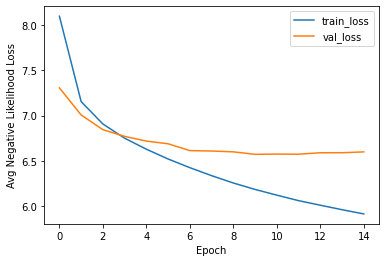

**Figure 1** Loss plot for `CBOW-2-hotel`

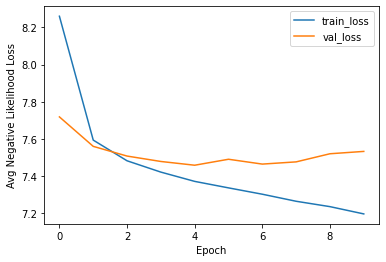

**Figure 2** Loss plot for `CBOW-5-hotel`

(❓1.5) In light of `Table 1` and `Figure 1-2`, it seems that increasing window size caused the model prediction to deviate more from the central target, evidenced by the increased average validation loss. We speculate that larger window, on one hand, brought more information to the model, but on the other hand, perplexed it at the same time, hence the raise in loss. `CBOW-5-hotel` also started to overfit earilier than `CBOW-2-hotel`, suggesting that it is potentially too complex.

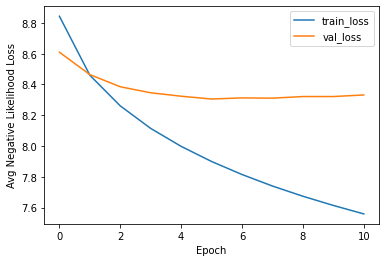

**Figure 3** Loss plot for `CBOW-2-scifi`

#### **5. Evaluation and Discussion**

We evaluated the quality of the learned word embeddings by looking at the closet neighbours of a selection of words. The neighbours were retrieved by computing the pairwise distance between the chosen words and each candidate embedding. We selected words based on frequency lists contructed for the hotel review and scifi corpora.

#### 5.1 `CBOW-2-hotel`

(❓2.1) The results for `CBOW-2-hotel` are shown in `Table 2`. In general, the neighbours for high frequency words are more or less sensible: for example. `restaurant` was correctly placed closely to related words like `food`, `tasty` and `disastrous. However, the model's performance on rare words was somewhat dissatisfactory but expected, as their limited occurrence posits difficulty for the model to correctly place them in the vector space. 

|Word|PoS|Frequency|Top 5 closest neighbours|
|:-|-:|-:|-:|
|service|noun|high|food, clean, nice, reasonabley, small|
|restaurant|noun|high|food, tasty, disastrous, scenery, racking|
|fireplace|noun|low|ripp, unique, niagara, sanitary, floral|
|friendly|adj|high|helpful, pleasant, nice, warm2, death|
|financial|adj|low|civilization, servicable, overshadow, indifference, calfs|
|grateful|adj|low|liasion, occupancy, mediteranean, representative, fferent|
|like|verb|high|want, use, come, expect, try|
|recommend|verb|high|book, stay, well, love, worth|
|yell|verb|low|rolling, rare, estimation, picture, complication|

**Table 2** Cloest neighbours retrieved by `CBOW-2-hotel`. 

#### 5.2 `CBOW-2-scifi`

(❓2.2, 2.3) `Table 3` presents the neighbours retrieved by `CBOW-2-scifi`. `CBOW-2-scifi` returned neighbours that are much more elusive in constrast to `CBOW-2-hotel`. Even the quality for highly frequent words was suboptimal. This might be due to the relatively large vocabulary size (shown in `Table 1`) where words might have a much more complex relationship with each other than co-occurrence. As shown in `Figure 3`, this model had the highest validation loss across the three models, and suffered greatly from overfitting. 

|Word|PoS|Frequency|Top 5 closest neighbours|
|:-|-:|-:|-:|
|power|noun|high|Sullivani, Galton, stigmatize, leaime, unschedule|
|mathematician|noun|low|boy, steadfastly, itiheir, Gripes, H.P.|
|compulsion|noun|low|sjcak, arresting, grease, ou#ost, luckier|
|hard|adj|high|Cookery, arresting, longdiscredited, etting, pm|
|absurd|adj|low|Suttleprobe, radius, Manual, Jhe, longdiscredited|
|ignorant|adj|low|Uw, Adamjs, Snerr, befog, tattooe|
|order|verb|high|say, gerly, unsay, Centaurs, m.fijcsty|
|catch|verb|high|let, raise, take, see, tkere|
|weaken|verb|low|Gross, Ayrabs, pagoda, googol, Erosine|

**Table 3** Cloest neighbours retrieved by `CBOW-2-scifi`

#### 5.3 Cross-model comparison

(❓2.4) We also compared neighbours of the same words retrieved by `CBOW-2-scifi` and `CBOW-2-hotel`. Two examples are given in `Table 4`. `Book` in the hotel dataset is more often associated with the sense of booking a hotel room, hence the neighbours `stay` and `pay`. The same goes for `night`, which was more related to the traditional sense of time (as opposed to `day`), and the time spent in a hotel room. These two words, however, have drastically different neighbours in the scifi dataset. This is firstly a result of messy dataset (as discussed above) consisting of many non-words like `ncte` and misspellings. 

More importantly, the semantic space in each embedding reflects the context in which the word is used, shaping the associations between words differently in each dataset. the Sci-fi-based embeddings reflect a more abstract and literary style of language. Words like `book` and `night` are associated with different themes in science fiction literature. These embeddings reflect a richer variety in terms of intellectual topics or narrative structures, which is typical for a Sci-fi corpus.

In general, the embeddings from the Sci-fi dataset are more abstract and tied to thematic elements, whereas the hotel review embeddings are more contextually grounded in practical, service-related words.

|Word|Model|Neighbours|
|:-|-:|-:|
|book|`CBOW-2-scifi`|ncte, Substitute, patri, ccwnpletely, fs|
|book|`CBOW-2-hotel`|stay, pay, choose, get, well|
|night|`CBOW-2-scifi`|Lugosi, tonner, friend, Equations, wilfly|
|night|`CBOW-2-hotel`|day, hotel, time, room, good|

#### **6. Conclusions**

(❓2.5) `CBOW-2` has context window size is 2, meaning it uses the two words surrounding a target word to predict the target word. It captures more local, immediate context and thus focuses on close relationships between words.

`CBOW-5`, on the other hand, has a larger context window of 5 words, meaning it considers a broader context around the target word. This might capture more semantic relationships and broader dependencies in the text but may miss out on very specific, local word pairings.

In practice, `CBOW-2` tends to perform better on datasets where close proximity word relationships are more important, such as in short, concise texts like reviews. `CBOW-5` might perform better in longer, more complex texts like Sci-fi narratives, where relationships between words might span over several tokens.